In [1]:
import NN_Module_Poly as nnm
import torch
import numpy as np
import numpy.ma as ma
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import math
import time
import pandas as pd
from pandas import read_csv
import argparse
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
out_file = '6755_13'

In [3]:
names = {}
names['cQei'] = 0
names['cQl3i'] = 1
names['cQlMi'] = 2
names['cbW'] = 3
names['cpQ3'] = 4
names['cpQM'] = 5
names['cpt'] = 6
names['cptb'] = 7
names['ctG'] = 8
names['ctW'] = 9
names['ctZ'] = 10
names['ctei'] = 11
names['ctlSi'] = 12
names['ctlTi'] = 13
names['ctli'] = 14
names['ctp'] = 15

WC_to_analyze_1 = ['cpQ3', 'cpQM', 'cpt', 'cptb', 'cQei', 'ctei', 'ctli', 'ctW'] # The first of the two WCs to graph
WC_to_analyze_2 = ['cbW', 'ctG', 'ctp', 'cQl3i', 'cQlMi', 'ctlTi', 'ctlSi', 'ctZ'] # The second of the two WCs to graph

batch_size = 1024

In [4]:
save_dict = torch.load(f'../models/{out_file}/{out_file}_model+.pt')
best_model_state = save_dict['model']
parameters_save = save_dict['parameters']
input_stats = save_dict['input_stats']
output_stats = save_dict['output_stats']

In [5]:
# Check to make sure we're on cuda
input_stats[0].device

device(type='cuda', index=0)

In [6]:
parameters_save

{'N': 16,
 'train_size': 49378587,
 'test_size': 498773,
 'hidden_nodes': 750,
 'hidden_layers': 2,
 'batch_size': 1024,
 'n_epochs': 152,
 'learning_rate': 0.0001,
 'lr_red_factor': 0.2,
 'lr_red_patience': 20.0,
 'lr_red_threshold': 1e-06,
 'weight_decay': 0.0,
 'accu_out_resolution': 100,
 'out_residual_resolution': 100}

In [7]:
model = nnm.create_model(16, 1, parameters_save)
model.load_state_dict(best_model_state)
model.eval()

Sequential(
  (0): PolynomialLayer(
    (monomial_layer): MonomialLayer()
    (linear): Linear(in_features=152, out_features=750, bias=True)
  )
  (1): ReLU()
  (2): Linear(in_features=750, out_features=750, bias=True)
  (3): ReLU()
  (4): Linear(in_features=750, out_features=750, bias=True)
  (5): ReLU()
  (6): Linear(in_features=750, out_features=1, bias=True)
)

In [8]:
actual_frozen_2D_data = {}
for num in np.arange(8):
    WC1 = WC_to_analyze_1[num]
    WC2 = WC_to_analyze_2[num]
    loaded = np.load(f'likelihood_{WC1}_{WC2}.npz')
    actual_frozen_2D_data[str(num)] = {WC1: loaded[WC1], WC2: loaded[WC2], 'deltaNLL': loaded['deltaNLL']}
    actual_frozen_2D_data[str(num)]['deltaNLL'] -= actual_frozen_2D_data[str(num)]['deltaNLL'].min()
    actual_frozen_2D_data[str(num)]['deltaNLL'] *= 2

In [9]:
actual_profiled_2D_data = {}
for num in np.arange(8):
    WC1 = WC_to_analyze_1[num]
    WC2 = WC_to_analyze_2[num]
    loaded = np.load(f'likelihood_profiled_{WC1}_{WC2}.npz')
    inputs = np.zeros((loaded['deltaNLL'].shape[0], 16))
    for key2 in names.keys():
        inputs[:,names[key2]] = loaded[key2]
    actual_profiled_2D_data[str(num)] = {'inputs': inputs, 'deltaNLL': loaded['deltaNLL']}
    actual_profiled_2D_data[str(num)]['deltaNLL'] -= actual_profiled_2D_data[str(num)]['deltaNLL'].min()
    actual_profiled_2D_data[str(num)]['deltaNLL'] *= 2

In [10]:
model_frozen_2D_data = {}
for num in np.arange(8):
    inputs_y = actual_frozen_2D_data[str(num)][WC_to_analyze_1[num]]
    inputs_x = actual_frozen_2D_data[str(num)][WC_to_analyze_2[num]]
    num_inputs = inputs_y.shape[0]
    inputs_all = np.zeros((num_inputs, 16))
    inputs_all[:,names[WC_to_analyze_1[num]]] = inputs_y
    inputs_all[:,names[WC_to_analyze_2[num]]] = inputs_x
    std_inputs = nnm.affine_transform(torch.from_numpy(inputs_all).float().cuda(), input_stats)
    std_outputs = model(std_inputs)
    #inputMiniBatches = torch.split(std_inputs, batch_size)
    #std_outputs = model(inputMiniBatches[0])
    #for minibatch in range(len(inputMiniBatches)-1):
    #    std_outputs = torch.cat((std_outputs, model(inputMiniBatches[minibatch+1])))
    outputs = nnm.affine_untransform(std_outputs, output_stats).cpu().detach().numpy().flatten()
    outputs -= outputs.min()
    outputs *= 2
    #model_frozen_2D_data[str(num)] = {WC_to_analyze_1[num]: inputs_y, WC_to_analyze_2[num]: inputs_x, 'deltaNLL': outputs}
    model_frozen_2D_data[str(num)] = {WC_to_analyze_1[num]: inputs_all[:,names[WC_to_analyze_1[num]]], WC_to_analyze_2[num]: inputs_all[:,names[WC_to_analyze_2[num]]], 'deltaNLL': outputs}

In [11]:
model_profiled_2D_data = {}
for num in np.arange(8):
    inputs = actual_profiled_2D_data[str(num)]['inputs']
    std_inputs = nnm.affine_transform(torch.from_numpy(inputs).float().cuda(), input_stats)
    std_outputs = model(std_inputs)
    outputs = nnm.affine_untransform(std_outputs, output_stats).cpu().detach().numpy().flatten()
    outputs -= outputs.min()
    outputs *= 2
    model_profiled_2D_data[str(num)] = {WC_to_analyze_1[num]: inputs[:,names[WC_to_analyze_1[num]]], WC_to_analyze_2[num]: inputs[:,names[WC_to_analyze_2[num]]], 'deltaNLL': outputs}

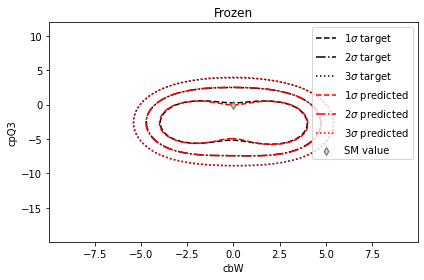

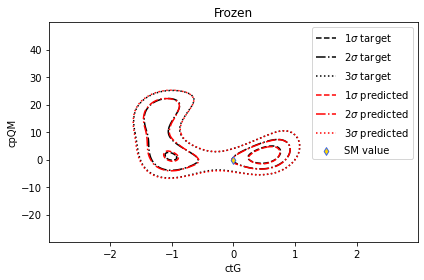

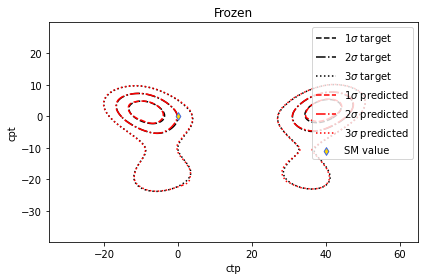

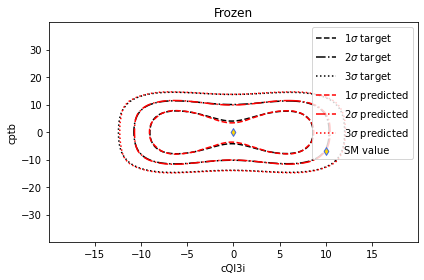

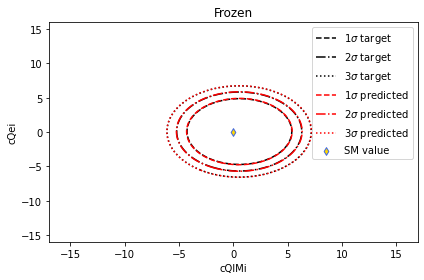

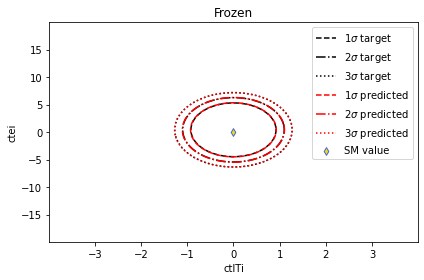

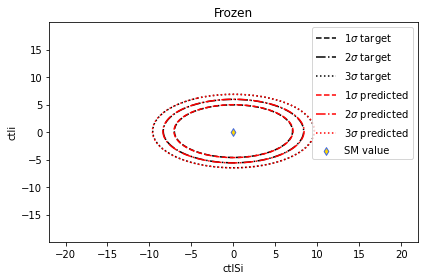

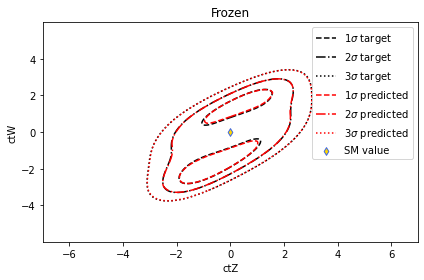

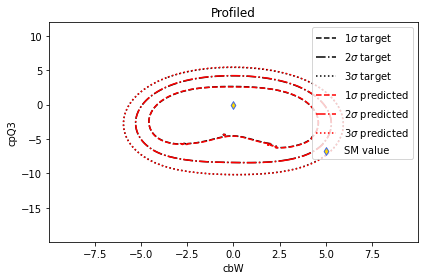

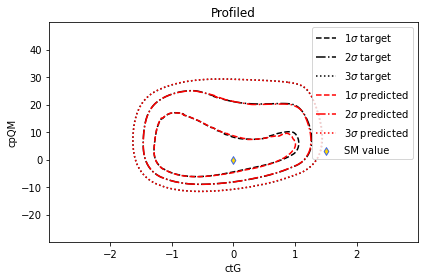

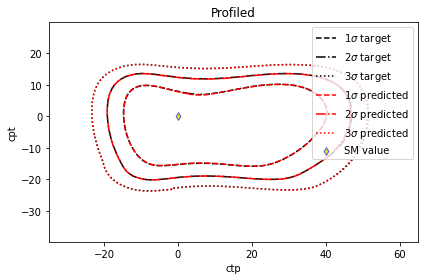

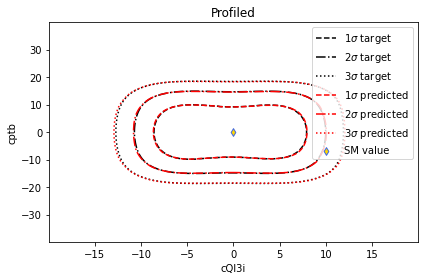

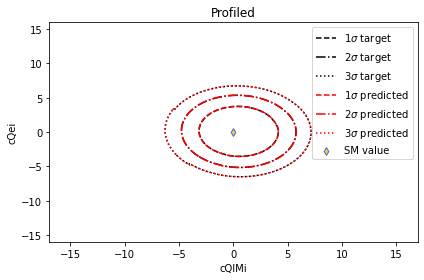

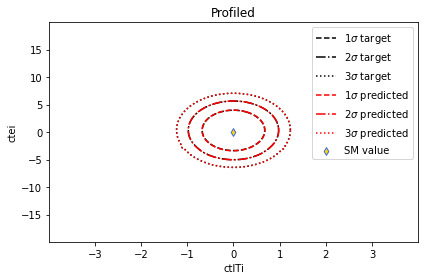

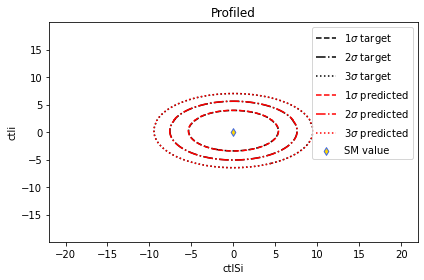

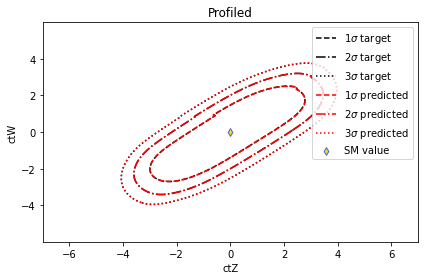

In [12]:
frozen_graphs = {}
profiled_graphs = {}
for num in np.arange(8):
    frozen_graphs[str(num)] = plt.subplots()
    actual_contour = frozen_graphs[str(num)][1].tricontour(actual_frozen_2D_data[str(num)][WC_to_analyze_2[num]], actual_frozen_2D_data[str(num)][WC_to_analyze_1[num]], actual_frozen_2D_data[str(num)]['deltaNLL'], colors='k', linestyles=['dashed', 'dashdot', 'dotted'], levels=[2.30, 6.18, 11.83]) # 1, 2, and 3 sigmas
    model_contour = frozen_graphs[str(num)][1].tricontour(model_frozen_2D_data[str(num)][WC_to_analyze_2[num]], model_frozen_2D_data[str(num)][WC_to_analyze_1[num]], model_frozen_2D_data[str(num)]['deltaNLL'], colors='r', linestyles=['dashed', 'dashdot', 'dotted'], levels=[2.30, 6.18, 11.83]) # 1, 2, and 3 sigmas
    SM_value = frozen_graphs[str(num)][1].scatter(0, 0, marker='d', c='gold', ec='royalblue', s=30, linewidths=1, zorder=10)
    frozen_graphs[str(num)][1].legend(actual_contour.collections+model_contour.collections+[SM_value], ['$1\sigma$ target', '$2\sigma$ target', '$3\sigma$ target', '$1\sigma$ predicted', '$2\sigma$ predicted', '$3\sigma$ predicted', 'SM value'])
    frozen_graphs[str(num)][1].set_xlabel(WC_to_analyze_2[num])
    frozen_graphs[str(num)][1].set_ylabel(WC_to_analyze_1[num])
    frozen_graphs[str(num)][1].set_title('Frozen')
    frozen_graphs[str(num)][0].tight_layout()
    
for num in np.arange(8):
    profiled_graphs[str(num)] = plt.subplots()
    actual_contour = profiled_graphs[str(num)][1].tricontour(model_profiled_2D_data[str(num)][WC_to_analyze_2[num]], model_profiled_2D_data[str(num)][WC_to_analyze_1[num]], actual_profiled_2D_data[str(num)]['deltaNLL'], colors='k', linestyles=['dashed', 'dashdot', 'dotted'], levels=[2.30, 6.18, 11.83]) # 1, 2, and 3 sigmas
    model_contour = profiled_graphs[str(num)][1].tricontour(model_profiled_2D_data[str(num)][WC_to_analyze_2[num]], model_profiled_2D_data[str(num)][WC_to_analyze_1[num]], model_profiled_2D_data[str(num)]['deltaNLL'], colors='r', linestyles=['dashed', 'dashdot', 'dotted'], levels=[2.30, 6.18, 11.83]) # 1, 2, and 3 sigmas
    SM_value = profiled_graphs[str(num)][1].scatter(0, 0, marker='d', c='gold', ec='royalblue', s=30, linewidths=1, zorder=10)
    profiled_graphs[str(num)][1].legend(actual_contour.collections+model_contour.collections+[SM_value], ['$1\sigma$ target', '$2\sigma$ target', '$3\sigma$ target', '$1\sigma$ predicted', '$2\sigma$ predicted', '$3\sigma$ predicted', 'SM value'])
    profiled_graphs[str(num)][1].set_xlabel(WC_to_analyze_2[num])
    profiled_graphs[str(num)][1].set_ylabel(WC_to_analyze_1[num])
    profiled_graphs[str(num)][1].set_title('Profiled')
    profiled_graphs[str(num)][0].tight_layout()

In [13]:
pp = PdfPages(f'{out_file}_validation_2D.pdf')
for key in frozen_graphs.keys():
    pp.savefig(frozen_graphs[key][0])
for key in profiled_graphs.keys():
    pp.savefig(profiled_graphs[key][0])
pp.close()